In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall

import re
from tqdm import tqdm
import gensim
import string

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
tweets = pd.read_csv("C:/Users/czvzxv/Desktop/Disaster_tweets/train.csv")
test = pd.read_csv("C:/Users/czvzxv/Desktop/Disaster_tweets/test.csv")
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Text(0, 0.5, 'samples')

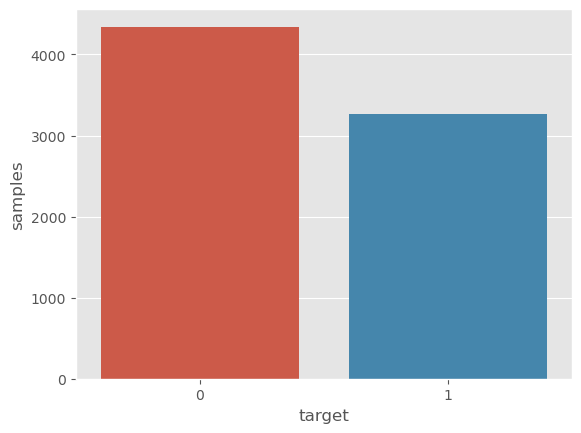

In [3]:
x=tweets.target.value_counts()
sns.barplot(x = x.index,y = x)
plt.gca().set_ylabel('samples')

Без катастроф твитов больше

## Проведём анализ данных

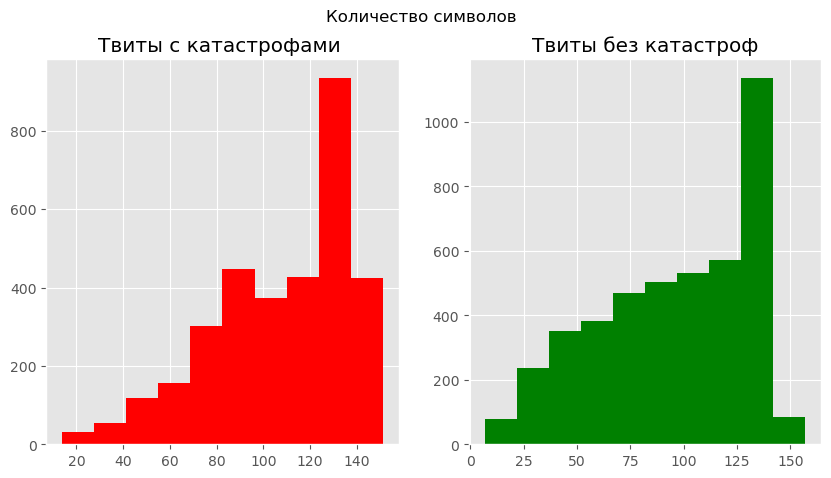

In [4]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweets[tweets['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('Твиты с катастрофами ')
tweet_len=tweets[tweets['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Твиты без катастроф')
fig.suptitle('Количество символов')
plt.show()

Распределение обоих вариантов, по-видимому, почти одинаковое. Наиболее распространенными являются 120–140 символов в твите(Считай максимальное количество почти)

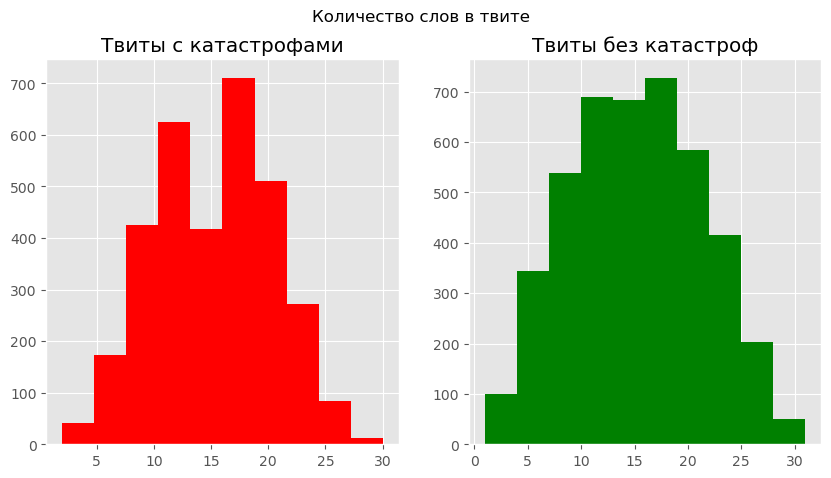

In [5]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweets[tweets['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('Твиты с катастрофами')
tweet_len=tweets[tweets['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Твиты без катастроф')
fig.suptitle('Количество слов в твите')
plt.show()

Text(0.5, 0.98, 'Средняя длина слова в каждом твите')

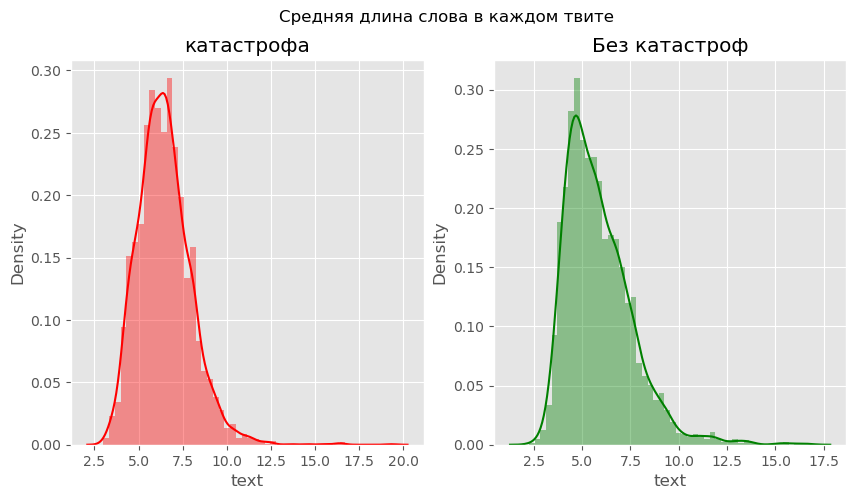

In [6]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweets[tweets['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('катастрофа')
word=tweets[tweets['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Без катастроф')
fig.suptitle('Средняя длина слова в каждом твите')

In [7]:
def create_corpus(target):
    corpus=[]
    
    for x in tweets[tweets['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [8]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

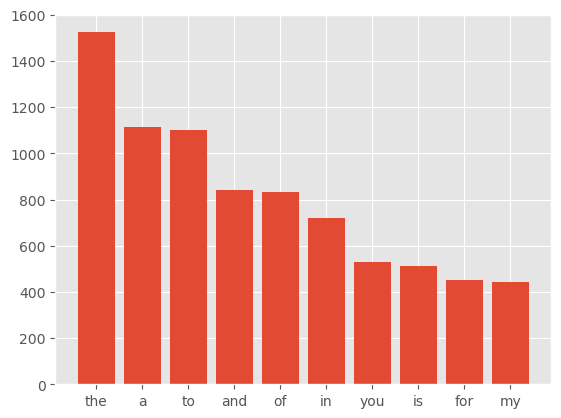

In [9]:
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

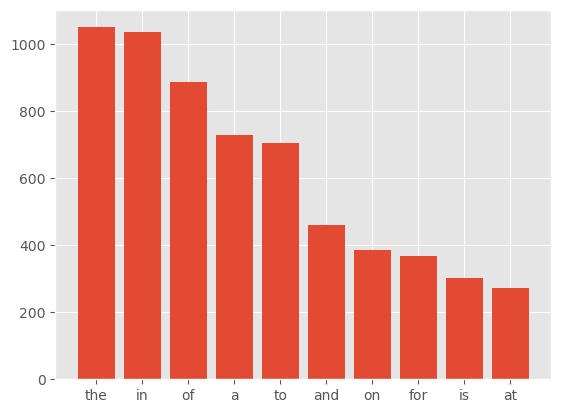

In [10]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y)

В обоих случаях доминирует «the», за которым в классе 0 следует «a», а в классе 1 — «in».

Что насчёт пунктуации?

<BarContainer object of 18 artists>

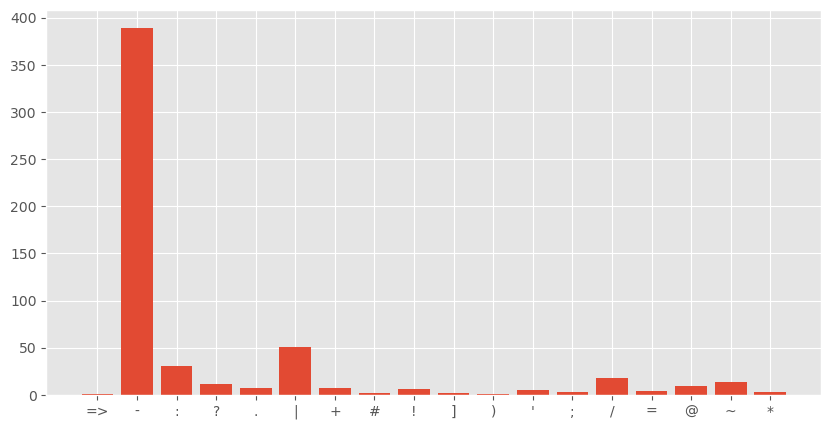

In [11]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

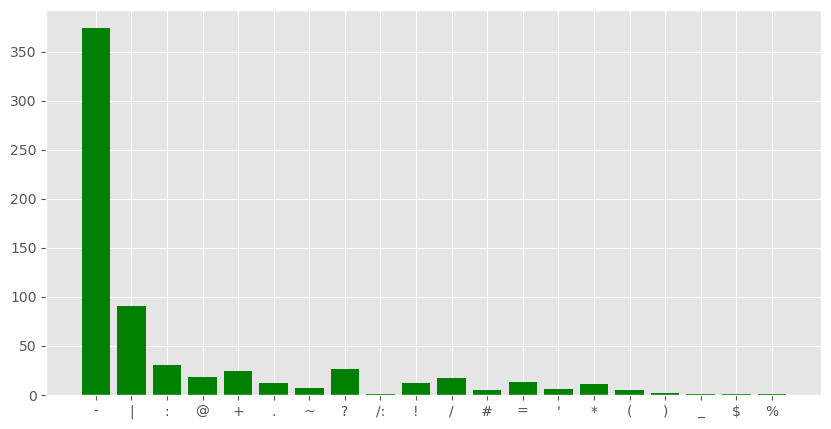

In [12]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

Часто встречаемые слова

In [13]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

<Axes: >

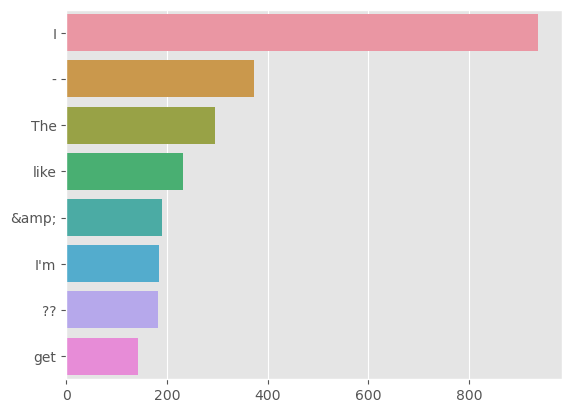

In [14]:
sns.barplot(x=y,y=x)

Можно взглянуть на биграмммы наших твитов

In [15]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

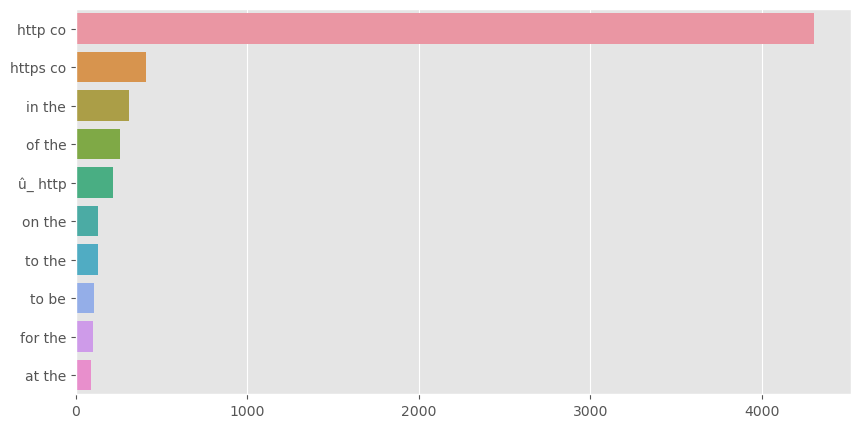

In [16]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweets['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

Что-то вообще не жизнерадостное нас тут встречает, придётся заняться очисткой

## Очистка данных

Ясное дело, твиты в Twitter(новом X)* всегда необходимо очищать, прежде чем приступать к моделированию. Поэтому мы выполним базовую очистку, такую как исправление орфографии, удаление знаков препинания, удаление HTML-тегов и эмодзи и т. д. Итак, начнем.

*социальная сеть заблокирована в РФ

In [17]:
data = pd.concat([tweets,test])
data.shape

(10876, 5)

Уберём ссылки

In [18]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [19]:
remove_URL('trash_text https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html')

'trash_text '

In [20]:
data['text']=data['text'].apply(lambda x : remove_URL(x))

Уберём теги разметки(HTML)

In [21]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html("""<div>
<h1>Poet</h1>
<p>Dostoevscky</p>
<a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html</a>
</div>"""))


Poet
Dostoevscky




In [22]:
data['text']=data['text'].apply(lambda x : remove_html(x))

Эмоджи тоже надо убрать бы, если имеются

In [23]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("OOOO CAKE REAL OR FAKE😬😬😬😬😬😬😬😬 - FAKE")

'OOOO CAKE REAL OR FAKE - FAKE'

In [24]:
data['text']=data['text'].apply(lambda x: remove_emoji(x))

Всякую фигню наподобие хэштегов тоже стоит подчистить

In [25]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="#I_LOVE_EGOR_KREED"
print(remove_punct(example))

ILOVEEGORKREED


In [26]:
data['text']=data['text'].apply(lambda x: remove_punct(x))

Ещё, может быть это кажется душноватым, но может стоит поправить правописание, если человек в твите ошибся

In [27]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "yoa stil myyr brothir"
correct_spellings(text)

'you still my brother'

## GloVe для Векторизации

In [28]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [29]:
corpus=create_corpus(data)

100%|██████████| 10876/10876 [00:00<00:00, 14502.75it/s]


In [30]:
embedding_dict={}
with open("C:/Users/czvzxv/Desktop/Disaster_tweets/glove.6B.100d.txt",'r',encoding='utf-8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [31]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [32]:
word_index=tokenizer_obj.word_index
print('Количество уникальных слов:',len(word_index))

Количество уникальных слов: 20342


In [33]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 602822.85it/s]


## Модель

In [34]:
def f1_score(y_true, y_pred):
    precision = Precision()(y_true, y_pred)
    recall = Recall()(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall + K.epsilon())

In [35]:
print(embedding_matrix.shape)

(20343, 100)


In [36]:
num_words

20343

In [37]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimizer=Adam(learning_rate=1e-5)

model.compile(loss = 'binary_crossentropy',optimizer = optimizer, metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
train=tweet_pad[:tweets.shape[0]]
test=tweet_pad[tweets.shape[0]:]

In [40]:
X_train,X_test,y_train,y_test=train_test_split(train,tweets['target'].values,test_size=0.15)
print('Размер train',X_train.shape)
print("Размер Validation ",X_test.shape)

Размер train (6471, 50)
Размер Validation  (1142, 50)


In [41]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
1618/1618 - 39s - 24ms/step - accuracy: 0.5696 - loss: 0.6910 - val_accuracy: 0.5727 - val_loss: 0.6882
Epoch 2/15
1618/1618 - 33s - 20ms/step - accuracy: 0.5758 - loss: 0.6762 - val_accuracy: 0.5963 - val_loss: 0.6337
Epoch 3/15
1618/1618 - 33s - 20ms/step - accuracy: 0.7041 - loss: 0.6032 - val_accuracy: 0.7732 - val_loss: 0.5286
Epoch 4/15
1618/1618 - 33s - 20ms/step - accuracy: 0.7331 - loss: 0.5718 - val_accuracy: 0.7732 - val_loss: 0.5087
Epoch 5/15
1618/1618 - 33s - 20ms/step - accuracy: 0.7385 - loss: 0.5689 - val_accuracy: 0.7750 - val_loss: 0.5042
Epoch 6/15
1618/1618 - 33s - 20ms/step - accuracy: 0.7364 - loss: 0.5619 - val_accuracy: 0.7802 - val_loss: 0.5020
Epoch 7/15
1618/1618 - 33s - 20ms/step - accuracy: 0.7470 - loss: 0.5514 - val_accuracy: 0.7793 - val_loss: 0.4978
Epoch 8/15
1618/1618 - 34s - 21ms/step - accuracy: 0.7475 - loss: 0.5520 - val_accuracy: 0.7820 - val_loss: 0.4938
Epoch 9/15
1618/1618 - 33s - 20ms/step - accuracy: 0.7506 - loss: 0.5524 - val_a

In [42]:
sample_sub=pd.read_csv("C:/Users/czvzxv/Desktop/Disaster_tweets/sample_submission.csv")

In [43]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('C:/Users/czvzxv/Downloads/submission.csv',index=False) #f1_score 0.78455

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
